### Business Understanding

Trying to predict heart health based on ECG timeseries data. Importnat because heart attacks are a leading cause of death in America

### Data Understanding

raw ECG data from Kaggle. Features extracted from raw data, https://www.kaggle.com/datasets/shayanfazeli/heartbeat

other people have attempted similar things

### Data Prep

Data is .csv all numerical readings. Requires feature extraction and correction for imbalanced classes. Minimum rows probably 50-70k. Visualizations TBD.

### Modeling

MOdelling techniques TBA depending on EDA / PCA. Baseline TBD - not sure. Maybe just always choosing dominant class for baseline? This is a classification problem.

### Evaluation

Will use Accuraccy, Precision, etc. MVP would be a ML Model incorporating extracted features. Then if a more advanced model makes sense I will try to implement that.

### Deployment

Was not planning on building a web app, just had in mind building a model that can classify heart condition based on ECG for now.

### Tools

see cell below. modeling algorithms tbd. so far my machine has been capable but I may need to move to google cloud if necessary computational power increases.

In [1]:
import pandas as pd
import numpy as np
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters

# If you need to plot or visualize data later on
import matplotlib.pyplot as plt
import seaborn as sns

# For any data preprocessing or manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Depending on the models you plan to use
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


## Dataset

In [2]:
fazeli_mitbih_train_df = pd.read_csv('../data/mitbih_train.csv', header=None)

In [4]:
column_187 = fazeli_mitbih_train_df.iloc[:, 187]
column_187.value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

## Comprehensive Feature Extraction

using tsfresh time series comprehensive feature extraction package

### without incremental (batches) approach


import pandas as pd
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters

# Load your dataset
fazeli_mitbih_train_df = pd.read_csv('../data/mitbih_train.csv', header=None)

# Separate out the target variable and assign a unique ID to each row
fazeli_mitbih_train_df['id'] = range(len(fazeli_mitbih_train_df))
target_series = fazeli_mitbih_train_df[187]

# Drop the target column to only keep features
fazeli_mitbih_train_df_features_only = fazeli_mitbih_train_df.drop(columns=[187])

# Convert to long format without the target variable
# Here, we preserve 'id' as it directly corresponds to the row index in the original dataset
long_df = fazeli_mitbih_train_df_features_only.melt(id_vars='id', var_name='time', value_name='amplitude')

extraction_settings = ComprehensiveFCParameters()

# Perform feature extraction
extracted_features = extract_features(long_df, column_id='id', column_sort='time', 
                                      default_fc_parameters=extraction_settings, n_jobs=7)

# Re-associate the target labels using the 'id' column
# Since 'id' was preserved through the feature extraction, it can be directly used to map back to the original labels
extracted_features['label'] = extracted_features.index.map(lambda idx: target_series[idx])

# Verify the re-association of labels with extracted features
print(extracted_features[['label']].head())


In [5]:
import pandas as pd
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters

# Load your dataset
fazeli_mitbih_train_df = pd.read_csv('../data/mitbih_train.csv', header=None)

# Assign a unique ID to each row and separate the target variable
fazeli_mitbih_train_df['id'] = range(len(fazeli_mitbih_train_df))
target_series = fazeli_mitbih_train_df[187]

# Keep only features and the unique ID for feature extraction
fazeli_mitbih_train_df_features_only = fazeli_mitbih_train_df.drop(columns=[187])

# Convert to long format, preserving the 'id' for direct mapping
long_df = fazeli_mitbih_train_df_features_only.melt(id_vars='id', var_name='time', value_name='amplitude')

# Define feature extraction settings
extraction_settings = ComprehensiveFCParameters()

# Incremental extraction setup
unique_ids = long_df['id'].unique()
subset_size = 10000  # Adjust based on your dataset size and memory constraints
extracted_features_list = []

for i in range(0, len(unique_ids), subset_size):
    subset_ids = unique_ids[i:i+subset_size]
    subset_df = long_df[long_df['id'].isin(subset_ids)]
    
    # Extract features for this subset
    subset_features = extract_features(subset_df, column_id='id', column_sort='time',
                                       default_fc_parameters=extraction_settings, n_jobs=7)
    extracted_features_list.append(subset_features)



Feature Extraction: 100%|███████████████████████| 35/35 [01:04<00:00,  1.84s/it]


In [6]:

# Combine extracted features from all subsets
extracted_features = pd.concat(extracted_features_list)

# Re-associate the target labels using the 'id' column
# This step correctly maps the original labels to the extracted features based on 'id'
extracted_features['label'] = extracted_features.index.map(lambda idx: target_series.loc[idx])

# Verify the re-association of labels
print(extracted_features[['label']].head())


   label
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0


# Ensure the target series has the same index range as the original dataframe
target_series = fazeli_mitbih_train_df[187].reset_index(drop=True)


# This assumes each `id` in `long_df` and thus in `extracted_features` 
# correctly maps back to the original row index in `fazeli_mitbih_t
rain_df`
extracted_features['label'] = extracted_features.index // len(fazeli_mitbih_train_df_features_only.columns) % len(target_series)
extracted_features['label'] = extracted_features['label'].apply(lambda x: target_series.iloc[x])


## Taking a look at the extracted data

In [7]:
extracted_features.head()


,amplitude__variance_larger_than_standard_deviation,amplitude__has_duplicate_max,amplitude__has_duplicate_min,amplitude__has_duplicate,amplitude__sum_values,amplitude__abs_energy,amplitude__mean_abs_change,amplitude__mean_change,amplitude__mean_second_derivative_central,amplitude__median,...,amplitude__fourier_entropy__bins_10,amplitude__fourier_entropy__bins_100,amplitude__permutation_entropy__dimension_3__tau_1,amplitude__permutation_entropy__dimension_4__tau_1,amplitude__permutation_entropy__dimension_5__tau_1,amplitude__permutation_entropy__dimension_6__tau_1,amplitude__permutation_entropy__dimension_7__tau_1,amplitude__query_similarity_count__query_None__threshold_0.0,amplitude__mean_n_absolute_max__number_of_maxima_7,label
0,0.0,0.0,1.0,1.0,18.404412,7.608654,0.021940,-0.005258,0.000139,0.061275,...,0.903995,1.762151,1.351280,2.072257,2.679390,3.035473,3.193625,NaN,0.878501,0.0
1,0.0,0.0,1.0,1.0,16.831909,6.285631,0.027341,-0.005162,0.000262,0.054131,...,1.026019,1.990158,1.435273,2.349871,3.138213,3.652543,3.943556,NaN,0.787139,0.0
2,0.0,0.0,1.0,1.0,11.613513,4.322286,0.023162,-0.005376,0.000920,0.005405,...,1.499320,2.979340,1.336042,1.875466,2.328855,2.591505,2.767173,NaN,0.635521,0.0
3,0.0,0.0,1.0,1.0,15.723757,6.158557,0.022055,-0.004975,0.000702,0.002762,...,0.838260,1.840945,1.094078,1.610731,2.057330,2.384749,2.654145,NaN,0.774270,0.0
4,0.0,0.0,1.0,1.0,21.798122,9.020939,0.025493,-0.005200,-0.000089,0.056338,...,0.671328,1.387650,1.483448,2.451926,3.405371,3.963423,4.187547,NaN,0.898055,0.0


In [8]:
extracted_features.describe()

,amplitude__variance_larger_than_standard_deviation,amplitude__has_duplicate_max,amplitude__has_duplicate_min,amplitude__has_duplicate,amplitude__sum_values,amplitude__abs_energy,amplitude__mean_abs_change,amplitude__mean_change,amplitude__mean_second_derivative_central,amplitude__median,...,amplitude__fourier_entropy__bins_10,amplitude__fourier_entropy__bins_100,amplitude__permutation_entropy__dimension_3__tau_1,amplitude__permutation_entropy__dimension_4__tau_1,amplitude__permutation_entropy__dimension_5__tau_1,amplitude__permutation_entropy__dimension_6__tau_1,amplitude__permutation_entropy__dimension_7__tau_1,amplitude__query_similarity_count__query_None__threshold_0.0,amplitude__mean_n_absolute_max__number_of_maxima_7,label
count,87554.0,87554.000000,87554.000000,87554.0,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,0.0,87554.000000,87554.000000
mean,0.0,0.023688,0.991457,1.0,32.590912,15.258945,0.023042,-0.004772,0.000357,0.142976,...,0.562851,1.588951,1.282986,1.969711,2.560386,2.919686,3.128365,NaN,0.777526,0.473376
std,0.0,0.152077,0.092035,0.0,19.741782,14.093191,0.005651,0.001312,0.000420,0.167686,...,0.375591,0.616124,0.231689,0.413527,0.609587,0.719836,0.761024,NaN,0.103437,1.143184
min,0.0,0.000000,0.000000,1.0,2.421384,1.158800,0.005401,-0.005376,-0.002050,0.000000,...,0.058914,0.117714,0.219653,0.295241,0.361007,0.410061,0.458161,NaN,0.249524,0.000000
25%,0.0,0.000000,1.000000,1.0,18.325901,6.826498,0.020014,-0.005376,0.000128,0.000000,...,0.234966,1.070947,1.140293,1.709801,2.157420,2.445170,2.639438,NaN,0.714689,0.000000
50%,0.0,0.000000,1.000000,1.0,27.142751,10.381154,0.022538,-0.005327,0.000290,0.077381,...,0.469474,1.548911,1.277691,1.971678,2.553746,2.894872,3.085702,NaN,0.781926,0.000000
75%,0.0,0.000000,1.000000,1.0,40.751316,17.784661,0.025082,-0.004943,0.000566,0.240379,...,0.834404,2.026271,1.461635,2.261328,2.963590,3.376670,3.603133,NaN,0.848468,0.000000
max,0.0,1.000000,1.000000,1.0,142.500000,118.638845,0.154252,0.004981,0.002367,0.859702,...,1.746779,3.504805,1.790814,3.128108,4.428021,5.023066,5.190838,NaN,1.000000,4.000000


In [10]:
extracted_features.corr()

,amplitude__variance_larger_than_standard_deviation,amplitude__has_duplicate_max,amplitude__has_duplicate_min,amplitude__has_duplicate,amplitude__sum_values,amplitude__abs_energy,amplitude__mean_abs_change,amplitude__mean_change,amplitude__mean_second_derivative_central,amplitude__median,...,amplitude__fourier_entropy__bins_10,amplitude__fourier_entropy__bins_100,amplitude__permutation_entropy__dimension_3__tau_1,amplitude__permutation_entropy__dimension_4__tau_1,amplitude__permutation_entropy__dimension_5__tau_1,amplitude__permutation_entropy__dimension_6__tau_1,amplitude__permutation_entropy__dimension_7__tau_1,amplitude__query_similarity_count__query_None__threshold_0.0,amplitude__mean_n_absolute_max__number_of_maxima_7,label
amplitude__variance_larger_than_standard_deviation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amplitude__has_duplicate_max,NaN,1.000000,0.133451,0.119244,0.136332,0.228387,0.125989,0.001846,0.002267,0.116830,...,0.009540,0.043230,0.002901,0.012075,0.014069,0.011601,0.003337,NaN,0.083052,NaN
amplitude__has_duplicate_min,NaN,0.133451,1.000000,0.593277,-0.413635,-0.296284,-0.269789,0.000859,-0.000620,-0.423520,...,0.003727,-0.042623,-0.326063,-0.341051,-0.348585,-0.336968,-0.316822,NaN,-0.218980,NaN
amplitude__has_duplicate,NaN,0.119244,0.593277,1.000000,-0.223085,-0.139274,-0.174652,0.000516,-0.000188,-0.225111,...,0.005123,-0.023405,-0.193660,-0.202601,-0.207105,-0.200125,-0.188103,NaN,-0.128519,NaN
amplitude__sum_values,NaN,0.136332,-0.413635,-0.223085,1.000000,0.917241,0.758727,-0.003460,0.001272,0.964491,...,0.008762,0.129707,0.765690,0.781500,0.787828,0.777999,0.756921,NaN,0.677046,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
amplitude__permutation_entropy__dimension_6__tau_1,NaN,0.011601,-0.336968,-0.200125,0.777999,0.536472,0.925349,-0.001895,-0.002913,0.633973,...,0.068091,0.244341,0.998265,0.999583,0.998724,1.000000,0.996570,NaN,0.862771,NaN
amplitude__permutation_entropy__dimension_7__tau_1,NaN,0.003337,-0.316822,-0.188103,0.756921,0.525439,0.923706,-0.001734,-0.003143,0.602572,...,0.084318,0.265567,0.998995,0.994977,0.991531,0.996570,1.000000,NaN,0.882485,NaN
amplitude__query_similarity_count__query_None__threshold_0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amplitude__mean_n_absolute_max__number_of_maxima_7,NaN,0.083052,-0.218980,-0.128519,0.677046,0.538422,0.888025,-0.001400,-0.001032,0.505216,...,0.189045,0.364137,0.877411,0.858945,0.849453,0.862771,0.882485,NaN,1.000000,NaN


In [58]:
extracted_features.corr()

,amplitude__sum_values,amplitude__median,amplitude__mean,amplitude__length,amplitude__standard_deviation,amplitude__variance,amplitude__root_mean_square,amplitude__maximum,amplitude__absolute_maximum,amplitude__minimum,label
amplitude__sum_values,1.000000,0.964491,1.000000,NaN,0.658001,0.638319,0.972663,0.489145,0.489145,0.269220,NaN
amplitude__median,0.964491,1.000000,0.964491,NaN,0.476056,0.471184,0.893341,0.334110,0.334110,0.282702,NaN
amplitude__mean,1.000000,0.964491,1.000000,NaN,0.658001,0.638319,0.972663,0.489145,0.489145,0.269220,NaN
amplitude__length,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amplitude__standard_deviation,0.658001,0.476056,0.658001,NaN,1.000000,0.951542,0.802020,0.844907,0.844907,0.037310,NaN
amplitude__variance,0.638319,0.471184,0.638319,NaN,0.951542,1.000000,0.766281,0.688262,0.688262,0.021969,NaN
amplitude__root_mean_square,0.972663,0.893341,0.972663,NaN,0.802020,0.766281,1.000000,0.644206,0.644206,0.237905,NaN
amplitude__maximum,0.489145,0.334110,0.489145,NaN,0.844907,0.688262,0.644206,1.000000,1.000000,0.043066,NaN
amplitude__absolute_maximum,0.489145,0.334110,0.489145,NaN,0.844907,0.688262,0.644206,1.000000,1.000000,0.043066,NaN
amplitude__minimum,0.269220,0.282702,0.269220,NaN,0.037310,0.021969,0.237905,0.043066,0.043066,1.000000,NaN


In [11]:
extracted_features.cov()

,amplitude__variance_larger_than_standard_deviation,amplitude__has_duplicate_max,amplitude__has_duplicate_min,amplitude__has_duplicate,amplitude__sum_values,amplitude__abs_energy,amplitude__mean_abs_change,amplitude__mean_change,amplitude__mean_second_derivative_central,amplitude__median,...,amplitude__fourier_entropy__bins_10,amplitude__fourier_entropy__bins_100,amplitude__permutation_entropy__dimension_3__tau_1,amplitude__permutation_entropy__dimension_4__tau_1,amplitude__permutation_entropy__dimension_5__tau_1,amplitude__permutation_entropy__dimension_6__tau_1,amplitude__permutation_entropy__dimension_7__tau_1,amplitude__query_similarity_count__query_None__threshold_0.0,amplitude__mean_n_absolute_max__number_of_maxima_7,label
amplitude__variance_larger_than_standard_deviation,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.0
amplitude__has_duplicate_max,0.0,0.140746,0.018596,0.011040,1.326560,1.479810,0.004035,9.377552e-07,8.219588e-07,0.006581,...,0.001158,0.008721,0.000667,0.005002,0.008344,0.007739,0.002227,NaN,0.008225,0.0
amplitude__has_duplicate_min,0.0,0.018596,0.137957,0.054382,-3.984762,-1.900629,-0.008555,4.320255e-07,-2.226096e-07,-0.023618,...,0.000492,-0.009353,-0.074190,-0.139875,-0.204668,-0.222555,-0.209292,NaN,-0.021470,0.0
amplitude__has_duplicate,0.0,0.011040,0.054382,0.060905,-1.427933,-0.593624,-0.003680,1.724969e-07,-4.488784e-08,-0.008341,...,0.000451,-0.003420,-0.029278,-0.055210,-0.080795,-0.087822,-0.082563,NaN,-0.008372,0.0
amplitude__sum_values,0.0,1.326560,-3.984762,-1.427933,672.706719,410.878591,1.680115,-1.214965e-04,3.187534e-05,3.755913,...,0.078739,1.936777,12.165696,22.381597,32.300885,35.881406,34.916349,NaN,4.635423,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
amplitude__permutation_entropy__dimension_6__tau_1,0.0,0.007739,-0.222555,-0.087822,35.881406,16.475604,0.140483,-4.562827e-06,-5.005980e-06,0.169259,...,0.039684,0.236629,1.087412,1.962662,2.807325,3.161947,3.151743,NaN,0.404978,0.0
amplitude__permutation_entropy__dimension_7__tau_1,0.0,0.002227,-0.209292,-0.082563,34.916349,16.140049,0.140262,-4.174525e-06,-5.402962e-06,0.160908,...,0.048608,0.254394,1.088429,1.954016,2.787673,3.151743,3.163233,NaN,0.414316,0.0
amplitude__query_similarity_count__query_None__threshold_0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amplitude__mean_n_absolute_max__number_of_maxima_7,0.0,0.008225,-0.021470,-0.008372,4.635423,2.454701,0.020014,-5.003812e-07,-2.633435e-07,0.020024,...,0.015475,0.049531,0.141884,0.250365,0.354460,0.404978,0.414316,NaN,0.069681,0.0


In [9]:
column_187_extracted = extracted_features['label']
column_187_extracted.value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: label, dtype: int64

## Trying a RFClassifier to get feature importances for extracted features

# Assuming `extracted_features` is your DataFrame and 'label' is the target
X = extracted_features.drop('label', axis=1)  # Features
y = extracted_features['label']  # Target

# Convert to numeric type if not already
y = y.astype(float)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


from sklearn.impute import SimpleImputer

# Initialize the imputer to replace missing values with the median of the column
imputer = SimpleImputer(strategy='median')

# Fit on the training data and transform it
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


from sklearn.feature_selection import VarianceThreshold

# Apply variance threshold to identify and remove constant features
sel = VarianceThreshold(threshold=0)
X_train_imputed_filtered = sel.fit_transform(X_train_imputed)
X_test_imputed_filtered = sel.transform(X_test_imputed)

# Recreate the list of feature names based on the mask from VarianceThreshold
# This assumes 'feature_names' was originally the list of all feature names before any transformations
mask = sel.get_support()
adjusted_feature_names = [name for name, include in zip(feature_names, mask) if include]

# Now, 'adjusted_feature_names' should correctly match the features considered by the model
# Ensure the length matches the number of feature importances
if len(adjusted_feature_names) != len(rf.feature_importances_):
    raise ValueError("The number of adjusted feature names does not match the number of feature importances")

# Create the DataFrame with the correct list of features
features_importances_df = pd.DataFrame({
    'feature': adjusted_feature_names,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print(features_importances_df.head())


# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model using the imputed data
rf.fit(X_train_imputed, y_train)


# Extract feature importances
importances = rf.feature_importances_

# Create a DataFrame for visualization
features_importances_df = pd.DataFrame({
    'feature': adjusted_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Display the most important features
print(features_importances_df.head())


## PCA

reduce our extracted features to their (vectorized?) principal components - our goal here is to make a model that predicts heart condition, not to assess the importance of and identify the primary ECG factors in identifying our target classification

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Assuming `extracted_features` contains your dataset and 'label' is the target column
X = extracted_features.drop('label', axis=1)
y = extracted_features['label']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Apply PCA
pca = PCA(n_components=0.95)  # Adjust n_components as needed
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Ensure no NaN values before applying PCA
assert not np.isnan(X_train_scaled).any(), "NaN values found in scaled training data"
assert not np.isnan(X_test_scaled).any(), "NaN values found in scaled test data"


In [19]:
np.shape(X_train_pca)

(70043, 252)

In [20]:
X_train_pca

array([[-2.92980903e+00,  3.64161663e-01,  6.66477341e+00, ...,
         2.67512119e-01, -7.26186577e-01,  2.66723511e-01],
       [ 2.31374837e+00, -6.47699228e+00, -3.18303167e+00, ...,
        -3.47469701e-02, -5.12692819e-01, -2.23656772e-01],
       [ 9.00681197e+00,  3.93034637e-01, -5.94481300e+00, ...,
        -1.79732452e-01,  3.21216594e-01, -2.21952846e-01],
       ...,
       [-7.50800691e+00,  4.95648593e+00,  2.89789997e+00, ...,
        -4.70230726e-01,  2.35362568e-01, -3.57989596e-03],
       [ 8.76184850e-01, -2.66322837e+00, -7.34671869e+00, ...,
         2.10615422e-01, -4.05998363e-01,  3.40180320e-01],
       [-1.23088025e+00,  4.37925616e+00,  6.49808110e+00, ...,
         1.08146529e-01, -3.64853981e-01,  3.41884514e-02]])

In [21]:
RandomForestClassifier?

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.


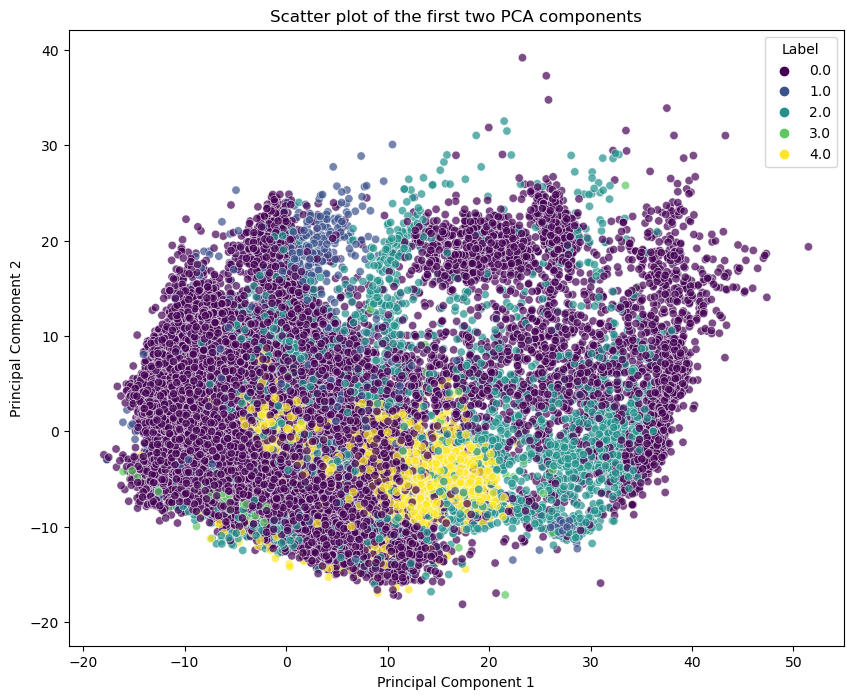

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_train_pca contains the PCA-transformed training data
# and y_train contains the corresponding labels

# Convert to DataFrame for easier plotting
pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
pca_df['label'] = y_train.reset_index(drop=True)  # Reset index to ensure alignment

# Plot the first two principal components
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='label', data=pca_df, palette='viridis', alpha=0.7)
plt.title('Scatter plot of the first two PCA components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Label')
plt.show()


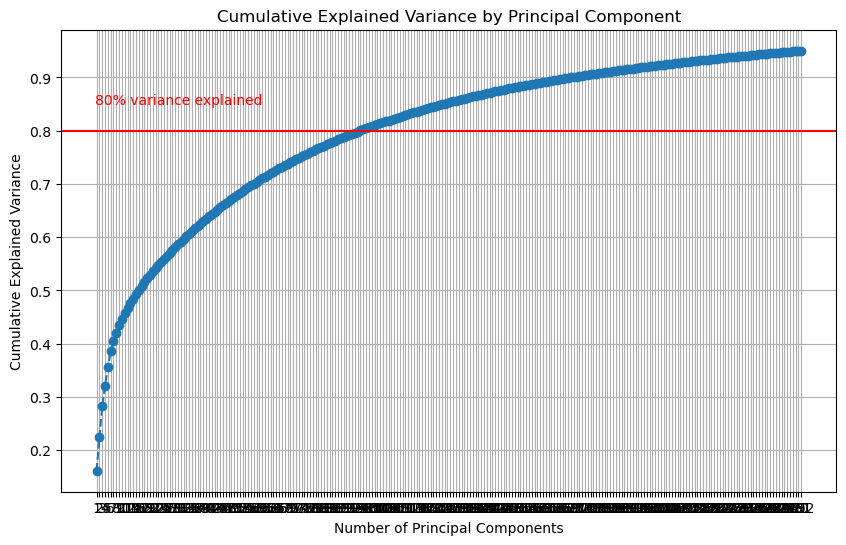

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `pca` is your PCA object after fitting
explained_variances = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variances)+1), explained_variances, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Component')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.xticks(range(1, len(explained_variances) + 1))

# Optional: Add a horizontal line to show 80% variance explained threshold
plt.axhline(y=0.8, color='r', linestyle='-')
plt.text(0.5, 0.85, '80% variance explained', color = 'red')

plt.show()


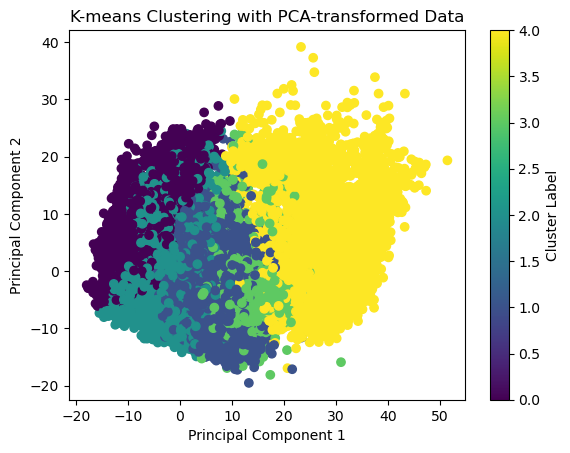

In [24]:
from sklearn.cluster import KMeans

# Choose the number of clusters
k = 5  # example, adjust based on your analysis

# Perform K-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_train_pca)

# Get cluster assignments for each data point
labels = kmeans.labels_

# Optionally, visualize the clusters
# This requires dimensionality reduction if you have more than 2 dimensions
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=labels)
plt.title('K-means Clustering with PCA-transformed Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


## Baseline Logistic Regression

At PCA .80

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Assuming `X_train_pca`, `X_test_pca`, `y_train`, and `y_test` are already defined

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model on the training data
log_reg.fit(X_train_pca, y_train)

# Predict on the test data
y_pred = log_reg.predict(X_test_pca)

# Evaluate the model
print("Baseline Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Baseline Model Accuracy: 0.9480897721432242

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     14579
         1.0       0.86      0.31      0.46       426
         2.0       0.84      0.75      0.79      1112
         3.0       0.84      0.50      0.63       145
         4.0       0.96      0.93      0.94      1249

    accuracy                           0.95     17511
   macro avg       0.89      0.70      0.76     17511
weighted avg       0.95      0.95      0.94     17511



at PCA .95

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Assuming `X_train_pca`, `X_test_pca`, `y_train`, and `y_test` are already defined

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model on the training data
log_reg.fit(X_train_pca, y_train)

# Predict on the test data
y_pred = log_reg.predict(X_test_pca)

# Evaluate the model
print("Baseline Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Baseline Model Accuracy: 0.9661355719262178

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     14579
         1.0       0.86      0.58      0.69       426
         2.0       0.90      0.84      0.87      1112
         3.0       0.80      0.70      0.75       145
         4.0       0.97      0.95      0.96      1249

    accuracy                           0.97     17511
   macro avg       0.90      0.81      0.85     17511
weighted avg       0.96      0.97      0.96     17511

